# Task 1: Genes
### Alina, Lisa, Ömer and Nikolai

## Import Data

In [1]:
# Load libraries
import os
import warnings
import time

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from tqdm import tqdm

In [2]:
# Configure libraries
warnings.filterwarnings("ignore")

In [3]:
# Set location of data directory
data_path = os.path.join("..","Data-PR-As2","Genes")

In [4]:
# Load dataset (this takes a while)
df = pd.read_csv(os.path.join(data_path, "data.csv"))
df_labels = pd.read_csv(os.path.join(data_path, "labels.csv"))

In [5]:
# Remove first columns as they just contain row names
df = df.iloc[:, 1:]
df_labels = df_labels.iloc[:, 1:]

## Data Analysis

In [6]:
# Dimensions of data
n_observations, n_features = df.shape
print("# observations:",n_observations," # features:", n_features)
classes = df_labels["Class"].unique()
n_classes = len(classes)
print("There are", n_classes, "classes:", classes)

# observations: 801  # features: 20531
There are 5 classes: ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']


In [7]:
# Remove samples to obtain a perfectly balanced set
def remove_class_samples(class_, num, df, df_labels):
    num -= 78
    remove_indices = df_labels.loc[df_labels['Class'] == class_].sample(n=num).index
    df_labels = df_labels.drop(remove_indices)
    df = df.drop(remove_indices)
    return df, df_labels

df, df_labels = remove_class_samples("BRCA", 300, df, df_labels)
df, df_labels = remove_class_samples("KIRC", 146, df, df_labels)
df, df_labels = remove_class_samples("LUAD", 141, df, df_labels)
df, df_labels = remove_class_samples("PRAD", 136, df, df_labels)

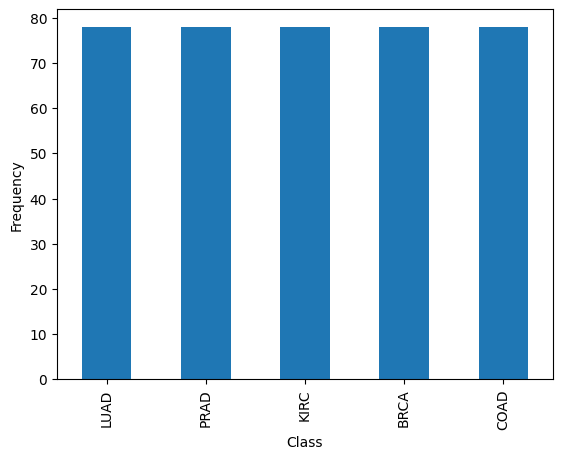

In [8]:
# Inspect frequency of class labels
ax = df_labels.apply(pd.value_counts).plot(kind='bar', legend=False)
if matplotlib.__version__[:3] == "3.5":
    ax.bar_label(ax.containers[0])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

There are 3 times more examples of BRCA than COAD. We therefore have a somewhat unbalanced dataset.

Min value: 0.0  Max value: 20.6155263691


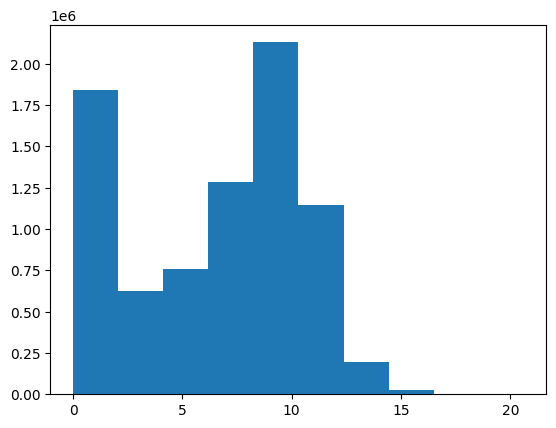

In [9]:
# Distribution of data across all features
df.stack().hist(grid=False)
df_np = df.to_numpy()
print("Min value:", df_np.min(), " Max value:", df_np.max())

In [10]:
# mean, std, min and max values vary between genes
df.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.0,390.000000,390.000000,390.000000,390.000000,...,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,0.022948,3.133328,3.183751,6.841027,9.759961,0.0,7.416306,0.513845,0.012415,0.003230,...,5.902528,8.724658,10.071733,4.233864,9.695333,11.767592,10.203518,9.521968,5.220764,0.080434
std,0.126259,1.191084,1.077419,0.706744,0.503296,0.0,1.091959,0.514266,0.104430,0.063795,...,0.760587,0.522676,0.368563,2.578232,0.537651,0.660127,0.553263,0.489583,2.076172,0.248101
min,0.000000,0.000000,0.000000,5.253146,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,3.272068,7.323865,8.808427,0.000000,8.223442,9.939708,8.097774,8.061771,0.593975,0.000000
25%,0.000000,2.452002,2.393942,6.319838,9.416322,0.0,6.696869,0.000000,0.000000,0.000000,...,5.467108,8.414061,9.829460,1.736659,9.353098,11.372046,9.886501,9.216990,3.714340,0.000000
50%,0.000000,3.248291,3.248231,6.744444,9.732150,0.0,7.535796,0.476277,0.000000,0.000000,...,5.943790,8.725467,10.072595,5.006851,9.706681,11.745056,10.258676,9.517472,4.952520,0.000000
75%,0.000000,3.981704,3.909414,7.210189,10.081673,0.0,8.113188,0.808303,0.000000,0.000000,...,6.402527,9.067340,10.313631,6.278060,10.049437,12.181983,10.592100,9.812653,6.480593,0.000000
max,1.482332,6.051542,5.848044,9.173387,11.355621,0.0,10.384363,2.263846,1.440686,1.259845,...,7.771054,11.105431,11.318243,9.207495,11.449443,13.600680,11.552194,11.471706,10.867147,1.841007


In [11]:
# Check dataframe for duplicate rows.
print(any(df.duplicated()))

False


In [12]:
def plot_tsne(x, y):
    tsne = TSNE(n_components=2, random_state=0)
    X_tsne = tsne.fit_transform(x)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y.to_numpy().flatten(), 
                    palette=sns.color_palette(n_colors=n_classes), data=y)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

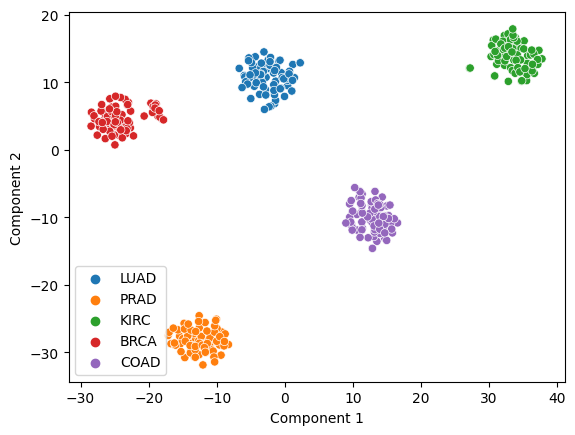

In [13]:
# Visualize multidimensional data
plot_tsne(df, df_labels)

## Feature Selection / Dimension Reduction

### PCA

In [14]:
def best_pca(components, x_train, y_train, x_test, y_test, model, normalizer=None):
    scores = []
    for n in tqdm(components):
        pca = PCA(n_components=n)
        x_train_norm, x_test_norm = (x_train, x_test)
        X_train_pca = pca.fit_transform(x_train_norm)
        x_test_pca = pca.transform(x_test_norm)
        model = SVC()
        y_pred = model.fit(X_train_pca, y_train).predict(x_test_pca)
        scores.append(accuracy_score(y_test, y_pred))
    return scores

100%|██████████| 10/10 [00:50<00:00,  5.00s/it]


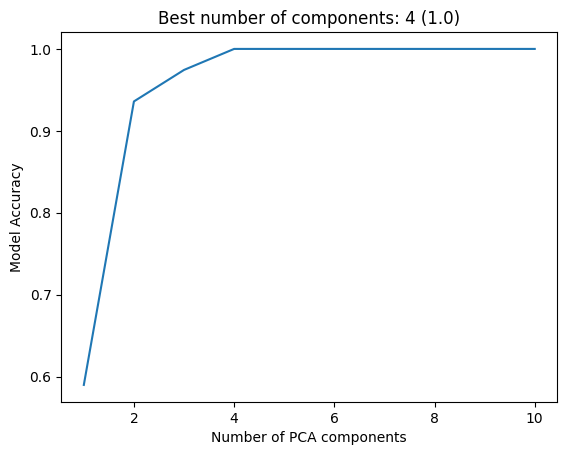

In [15]:
max_comp = 10
components = list(range(1, max_comp + 1))
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=0)
scores = best_pca(components, X_train, y_train, X_test, y_test, SVC(), None)
plt.plot(components, scores)
plt.xlabel("Number of PCA components")
plt.ylabel("Model Accuracy")
plt.title("Best number of components: " + str(np.argmax(scores) + 1) + " (" + str(round(max(scores),3)) + ")")
plt.show()

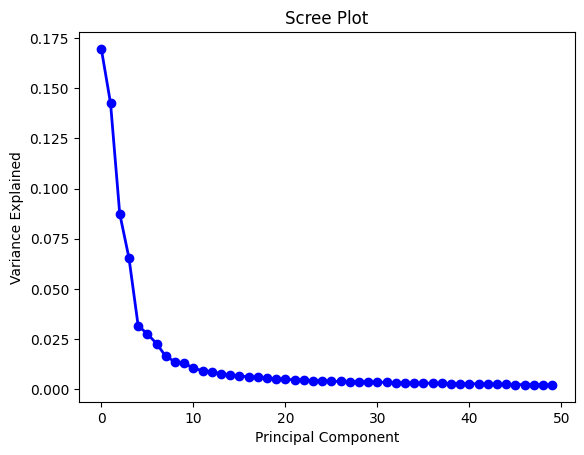

In [16]:
total_components = 50
pca = PCA(n_components=total_components)
pca.fit(X_train)
plt.plot(list(range(total_components)), pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### Mutual Information

In [17]:
# This takes like a minute to run
selector = SelectKBest(mutual_info_classif, k="all")
selector.fit(X_train, y_train)
feature_importance = np.flip(np.argsort(selector.scores_))

In [18]:
def best_mutual_info(top_n_feat, top_features, x_train, y_train, x_test, y_test, model):
    scores = []
    for i in tqdm(range(1, top_n_feat + 1)):
        best_cols = top_features[:i]
        reduced_x_train = X_train.iloc[:,best_cols]
        reduced_x_test = X_test.iloc[:,best_cols]
        y_pred = model.fit(reduced_x_train, y_train).predict(reduced_x_test)
        scores.append(accuracy_score(y_test, y_pred))
    return scores

100%|██████████| 20/20 [00:00<00:00, 402.51it/s]


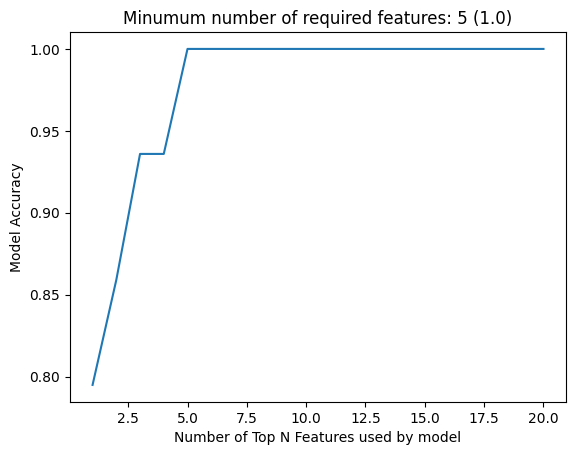

Top 5 genes: [ 6593  7964  7965 17109 18381]


In [19]:
top_n_feat = 20
scores = best_mutual_info(top_n_feat, feature_importance, X_train, y_train, X_test, y_test, SVC())
plt.plot(list(range(1,top_n_feat + 1)), scores)
plt.xlabel("Number of Top N Features used by model")
plt.ylabel("Model Accuracy")
min_feat = np.argmax(scores) + 1
plt.title(f"Minumum number of required features: {min_feat} ({round(max(scores),3)})")
plt.show()
print(f"Top {min_feat} genes: {np.sort(feature_importance[:min_feat])}")

## Classification (K-fold)

In [20]:
def get_train_test(type_: str, X_train, X_test, pca):
    if type_ == "PCA":
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    return X_train, X_test

def cross_val(model, df, df_labels, type_: str):
    pca = PCA(n_components=3)
    pred_times = []
    acc = []

    start_train = time.time()
    kf = StratifiedKFold(n_splits=5)
    for train_index, test_index in kf.split(df, df_labels):
        X_train, X_test = [df.iloc[i] for i in train_index], [df.iloc[i] for i in test_index]
        y_train, y_test = [df_labels.iloc[i] for i in train_index], [df_labels.iloc[i] for i in test_index]
        X_train, X_test = get_train_test(type_, X_train, X_test, pca)
        out = model.fit(X_train, y_train)
        start_pred = time.time()
        y_pred = out.predict(X_test)
        end_pred = time.time()
        pred_times.append(end_pred - start_pred)
        acc.append(accuracy_score(y_test, y_pred))
    end_train = time.time()

    print(f"Model: {model}, with{'out' if type_ != 'PCA' else ''} PCA")
    print("avg training diff:", (end_train - start_train)/5)
    print("avg predicting diff:", sum(pred_times)/5)
    print("avg predicting acc:", sum(acc)/5)
    print("------------------------------------------")

In [21]:
model = SVC()
cross_val(model, df, df_labels, "n")
cross_val(model, df, df_labels, "PCA")

model = GaussianNB()
cross_val(model, df, df_labels, "n")
cross_val(model, df, df_labels, "PCA")

model = KNeighborsClassifier(n_neighbors=3)
cross_val(model, df, df_labels, "n")
cross_val(model, df, df_labels, "PCA")


Model: SVC(), without PCA
avg training diff: 1.0737497329711914
avg predicting diff: 0.26438055038452146
avg predicting acc: 0.9948717948717949
------------------------------------------
Model: SVC(), with PCA
avg training diff: 3.760392189025879
avg predicting diff: 0.00040297508239746095
avg predicting acc: 0.9589743589743589
------------------------------------------
Model: GaussianNB(), without PCA
avg training diff: 0.08939757347106933
avg predicting diff: 0.01984539031982422
avg predicting acc: 0.8897435897435898
------------------------------------------
Model: GaussianNB(), with PCA
avg training diff: 3.9974525928497315
avg predicting diff: 0.00016164779663085938
avg predicting acc: 0.9461538461538461
------------------------------------------
Model: KNeighborsClassifier(n_neighbors=3), without PCA
avg training diff: 0.09555220603942871
avg predicting diff: 0.04545578956604004
avg predicting acc: 1.0
------------------------------------------
Model: KNeighborsClassifier(n_neigh